In [96]:
import glob
import os
import sys
import pdb
import os.path as osp
sys.path.append(os.getcwd())

import numpy as np
import pickle as pk
from scipy.spatial.transform import Rotation as sRot
import matplotlib.pyplot as plt
import joblib
from uhc.utils.math_utils import smpl_op_to_op
from embodiedpose.models.humor.body_model.utils import smpl_to_openpose
from embodiedpose.models.humor.utils.humor_mujoco import SMPL_2_OP
from embodiedpose.models.humor.utils.humor_mujoco import OP_14_to_OP_12


def xyxy2xywh(bbox):
    x1, y1, x2, y2 = bbox

    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    return [cx, cy, w, h]




smpl2op_map = smpl_to_openpose("smpl",
                                use_hands=False,
                                use_face=False,
                                use_face_contour=False,
                                openpose_format='coco25')
smpl_2op_submap = smpl2op_map[smpl2op_map < 22]


In [30]:
base_path = "/hdd/zen/dev/meta/HybrIK/"
res_data = pk.load(open(osp.join(base_path, 'res_dance_1/res.pk'), "rb"))

In [31]:
res_data.keys()

dict_keys(['pred_uvd', 'pred_xyz_17', 'pred_xyz_29', 'pred_xyz_24_struct', 'pred_scores', 'pred_camera', 'pred_betas', 'pred_thetas', 'pred_phi', 'pred_cam_root', 'transl', 'transl_camsys', 'bbox', 'height', 'width', 'img_path'])

In [123]:
pose_mat = np.array(res_data['pred_thetas'])
trans = np.array(res_data['transl']).squeeze()
bbox = np.array(res_data['bbox']).squeeze()

B = pose_mat.shape[0]
pose_aa = sRot.from_matrix(pose_mat.reshape(-1, 3, 3)).as_rotvec().reshape(B, -1)

transform = sRot.from_euler('xyz', np.array([-np.pi / 2, 0, 0]), degrees=False)
new_root = (transform * sRot.from_rotvec(pose_aa[:, :3])).as_rotvec()
pose_aa[:, :3] = new_root
transform.as_matrix(), sRot.from_rotvec(pose_aa[0, :3]).as_matrix()
trans = trans.dot(transform.as_matrix().T)
trans[:, 2] = trans[:, 2] - (trans[0, 2] - 0.92)

scale = (bbox[:, 2] - bbox[:, 0]) / 256
trans[:, 1] = trans[:, 1] / scale
beta = res_data['pred_betas'][0]


In [110]:
kp_25  = np.zeros([B, 25, 3])
kp_25_idxes = np.arange(25)[SMPL_2_OP][OP_14_to_OP_12] # wow this needs to get better...

uv_29 = res_data['pred_uvd'][:, :24]
pts_12 =smpl_op_to_op(uv_29[:, smpl_2op_submap, :])
kp_25[:, kp_25_idxes] = pts_12


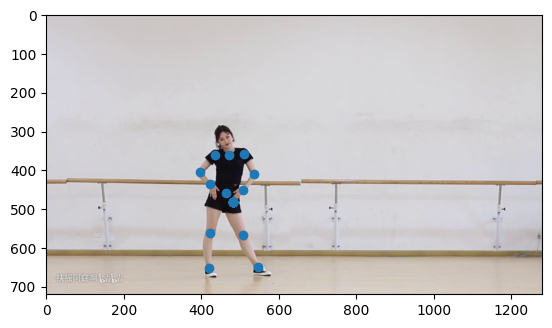

In [114]:
idx = 0
bbox_xywh = xyxy2xywh(bbox[idx])


uv_29 = kp_25[idx]

pts = uv_29 * bbox_xywh[2]
pts[:, 0] = pts[:, 0] + bbox_xywh[0]
pts[:, 1] = pts[:, 1] + bbox_xywh[1]

im = plt.imread(osp.join(base_path, res_data['img_path'][idx]))
plt.scatter(pts[:, 0], pts[:, 1])
plt.imshow(im)


In [145]:

full_R = sRot.from_euler("xyz", np.array([0, 0, 0])).as_matrix()
full_t = np.array([0, 0, 0])
K =  np.array([[640   ,   0,  res_data['width'][0]/2  ],
               [   0.              , 640   ,  res_data['height'][0]/2  ],
               [   0.              ,    0.              ,    1.              ]])


cam = {
    "full_R": full_R, 
    "full_t": full_t, 
    "K": K,
    'img_w': res_data['width'][0],
     'img_h': res_data['height'][0],
     'scene_name': None
}

In [146]:
pose_mat = sRot.from_rotvec(pose_aa.reshape(B * 24, 3)).as_matrix().reshape(B, 24, 3, 3)
pose_body = pose_mat[:, 1:22]
root_orient = pose_mat[:, 0:1]
new_dict = {}
start = 0
end = B
key = '01'
new_dict[key] = {
    "joints2d": kp_25[start:end].copy(),
    "pose_body": pose_body[start:end], 
    "root_orient": root_orient[start:end],
    "trans": trans.squeeze()[start:end],
    "pose_aa" : pose_aa.reshape(-1, 72)[start:end],
    "joints": np.zeros([B, 22, 3]),
    "seq_name": "01",
    "pose_6d": np.zeros([B, 24, 6]), 
    'betas': beta,
    "gender": "neutral", 
    "seq_name": key,
    "trans_vel": np.zeros([B, 1, 3]), 
    "joints_vel": np.zeros([B, 22, 3]), 
    "root_orient_vel": np.zeros([B, 1, 3]), 
    "points3d": None,
    "cam": cam
}
joblib.dump(new_dict, "sample_data/smpl_processed.pkl")

['sample_data/smpl_processed.pkl']